In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Evangelos Papoutsellis (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)     

# Primal Dual Hybrid Gradient Algorithm

In this demo, we learn how to use the **Primal Dual Hybrid Algorithm (PDHG)** introduced by [Chambolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document) for Tomography Reconstruction. We will solve the following minimisation problem under three different regularisation terms, i.e., 

* $\|\cdot\|_{1}$ or
* Tikhonov regularisation or
* with $L=\nabla$ and Total variation:


<a id='all_reg'></a>
$$
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} +
\underbrace{
\begin{cases}
\alpha\,\|u\|_{1}, & \\[10pt]
\alpha\,\|\nabla u\|_{2}^{2}, & \\[10pt]
\alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq 0\}}(u).
\end{cases}}_{Regularisers}
\tag{all reg}
$$

where,

1. $g$ is the Acquisition data obtained from the detector.

1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $\mathcal{A} : \mathbb{X} \rightarrow \mathbb{Y}, $ where $\mathbb{X}$ is an __ImageGeometry__ and $\mathbb{Y}$ is an __AcquisitionGeometry__.

1. $\alpha$: regularising parameter that measures the trade-off between the fidelity and the regulariser terms.

1. The total variation (isotropic) is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$

1. $\mathbb{I}_{\{u\geq 0\}}(u) : = 
\begin{cases}
0, & \text{ if } u\geq 0\\
\infty , & \text{ otherwise}
\,
\end{cases}
$, $\quad$ a non-negativity constraint for the minimiser $u$.

# Learning objectives

- Load the data using the CIL reader: `ZEISSDataReader`.
- Preprocess the data using the CIL processors:  `Binner`, `TransmissionAbsorptionConverter`.
- Run FBP and SIRT reconstructions.
- Setup PDHG for 3 different regularisers: $L^{1}$, Tikhonov and Total variation.

<!---
1. Brief intro for non-smooth minimisation problems using PDHG algorithm.
1. Setup and run PDHG with (__non-smooth__) $L^{1}$ norm regulariser. __(No BlockFramework)__
1. Use __BlockFunction__ and __Block Framework__ to setup PDHG for Tikhonov and TV reconstructions.
1. Run Total variation reconstruction with different regularising parameters and compared with FBP and SIRT reconstructions.
    

At the end of this demo, we will be able to reproduce all the reconstructions presented in the figure below. One can observe that the __Tikhonov regularisation__ with $L = \nabla$ was able to remove the noise but could not preserve the edges. However, this can be achieved with the the total variation reconstruction.

<img src="CIL-Demos/Notebooks/images/recon_all_tomo.jpeg"  width="1500"/>
--->

<!-- <h2><center><u> Prerequisites </u></center></h2>

- AcquisitionData, AcquisitionGeometry, AstraProjectorSimple.
- BlockOperator, Gradient.
- FBP, SIRT, CGLS, Tikhonov. -->

We first import all the necessary libraries for this notebook.

<!---
In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    
    
2. $K$ is a continuous linear operator acting from a space X to another space Y :

$$K : X \rightarrow Y \quad $$ 

with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: The Gradient operator  has  $\|\nabla\| = \sqrt{8} $ and for the projection operator we use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.

--->

In [2]:
# Import libraries

from cil.framework import BlockDataContainer

from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import ZEISSDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer

import matplotlib.pyplot as plt

import numpy as np

import os

# Data information

In this demo, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

 - https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

## Load walnut data

In [3]:
path = '/home/bih17925/CIL_demos/data/valnut/'

In [4]:
reader = ZEISSDataReader()
filename = os.path.join(path, "valnut_2014-03-21_643_28","tomo-A","valnut_tomo-A.txrm")
data3D = ZEISSDataReader(file_name=filename).read()

In [5]:
# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

### Acquisition and Image geometry information

In [6]:
print(ag3D)

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1601
	Angles 0-20 in radians:
[-3.1415665, -3.1377017, -3.1337626, -3.1298182, -3.125836 , -3.1219127,
 -3.1180956, -3.1140666, -3.1101887, -3.1062822, -3.1022923, -3.0984268,
 -3.0944946, -3.0905435, -3.0865552, -3.082691 , -3.0787866, -3.074828 ,
 -3.0708766, -3.0669732]
Distances in units: units distance


In [7]:
print(ig3D)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x1024,y1024,z1024
voxel_size : x0.04607780456542968,y0.04607780456542968,z0.04607780456542968
center : x0,y0,z0



### Show Acquisition geometry and full 3D sinogram.

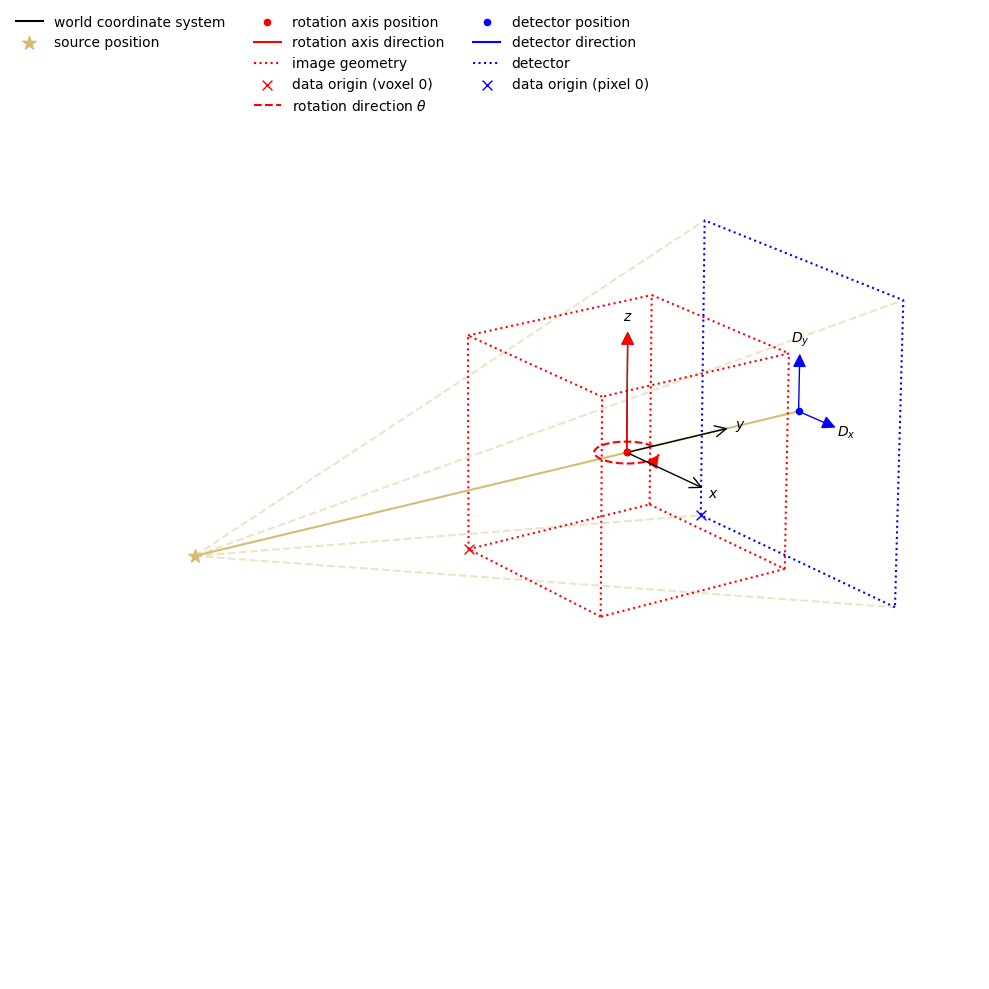

In [8]:
show_geometry(ag3D)

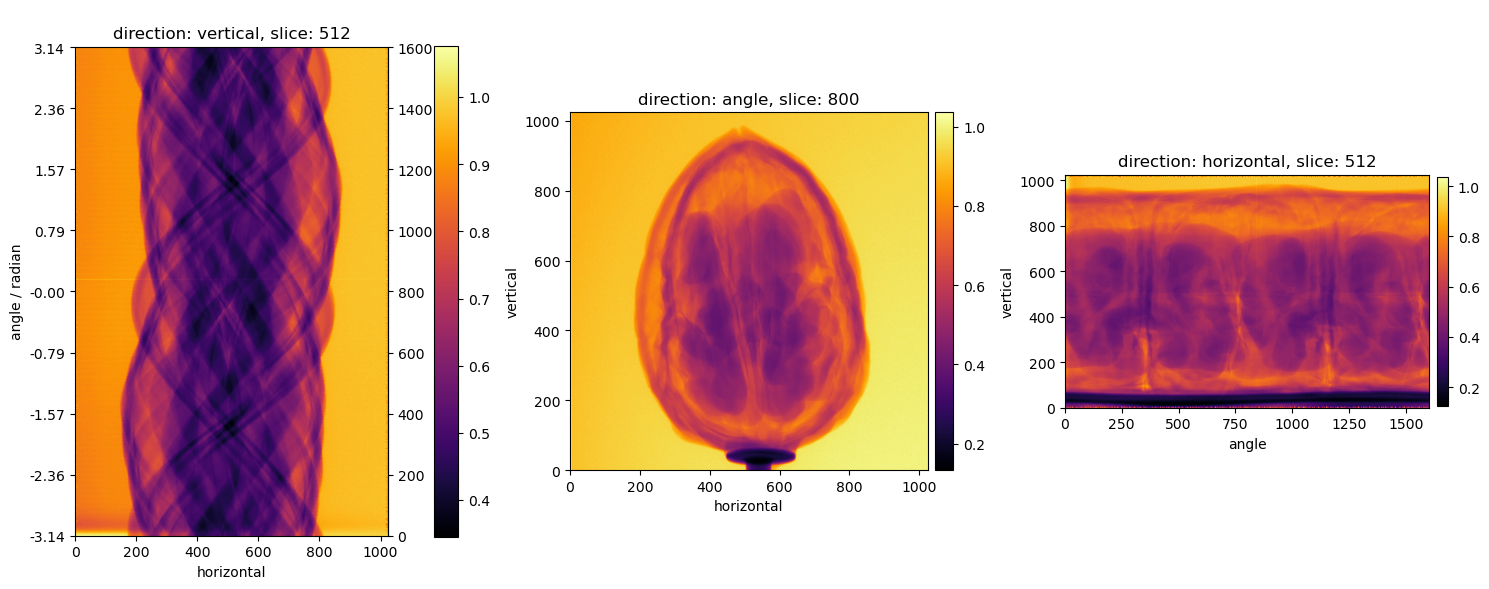

In [9]:
show2D(data3D, slice_list = [('vertical',512), ('angle',800), ('horizontal',512)], cmap="inferno", num_cols=3, size=(15,15))

### Slice through projections

In [10]:
islicer(data3D, direction=1, cmap="inferno")

### For demonstration purposes, we extract the central slice and select only 160 angles from the total 1601 angles.

1. We use the `Slicer` processor with step size of 10.
1. We use the `Binner` processor to crop and bin the acquisition data in order to reduce the field of view.
1. We use the `TransmissionAbsorptionConverter` to convert from transmission measurements to absorption based on the Beer-Lambert law.

**Note:** To avoid circular artifacts in the reconstruction space, we subtract the mean value of a background Region of interest (ROI), i.e., ROI that does not contain the walnut.

In [11]:
# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1600,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
absorption_data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
absorption_data -= np.mean(absorption_data.as_array()[80:100,0:30])

In [12]:
# Get Image and Acquisition geometries for one slice
ag2D = absorption_data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

In [13]:
print(" Acquisition Geometry 2D: {} with labels {}".format(ag2D.shape, ag2D.dimension_labels))
print(" Image Geometry 2D: {} with labels {}".format(ig2D.shape, ig2D.dimension_labels))

 Acquisition Geometry 2D: (160, 392) with labels ('angle', 'horizontal')
 Image Geometry 2D: (392, 392) with labels ('horizontal_y', 'horizontal_x')


### Define Projection Operator 
We can define our projection operator using our __astra__ __plugin__ that wraps the Astra-Toolbox library.

In [14]:
A = ProjectionOperator(ig2D, ag2D, device = "gpu")

## FBP and SIRT reconstructions

Now, let's perform simple reconstructions using the **Filtered Back Projection (FBP)** and **Simultaneous Iterative Reconstruction Technique** (see the [appendix](../appendix.ipynb) for more details).

Recall, for FBP we type


```python

    fbp_recon = FBP(ig, ag, device = 'gpu')(absorption_data)
            
```



For SIRT, we type

    
```python
    
    x_init = ig.allocate()
    sirt = SIRT(initial = x_init, operator = A, data=absorption_data, 
            max_iteration = 50, update_objective_interval=10)
    sirt.run(verbose=1)
    sirt_recon = sirt.solution 
       
```

**Note**: In SIRT, a non-negative constraint can be used with


```python    
    
    constraint=IndicatorBox(lower=0)        
    
```
   

### **Exercise 1: Run FBP and SIRT reconstructions**

Use the code blocks described above and run FBP (`fbp_recon`) and SIRT (`sirt_recon`) reconstructions.

**Note**: To display the results, use 

    
```python    
    
    show2D([fbp_recon,sirt_recon], title = ['FBP reconstruction','SIRT reconstruction'], cmap = 'inferno')        
    
```



In [15]:
# Setup and run the FBP algorithm
fbp_recon = FBP(..., ...,  device = 'gpu')(absorption_data)

# Setup and run the SIRT algorithm, with  non-negative constraint
x_init = ig2D.allocate()  
sirt = SIRT(initial = x_init, 
            operator = ..., 
            data= ..., 
            constraint = ...,
            max_iteration = 300, 
            update_objective_interval=100)
sirt.run(verbose=1)
sirt_recon = sirt.solution

# Show reconstructions
show2D([fbp_recon,sirt_recon], 
       title = ['FBP reconstruction','SIRT reconstruction'], 
       cmap = 'inferno', fix_range=(0,0.05))

AttributeError: 'ellipsis' object has no attribute 'dimension_labels'

### **Exercise 1: Solution**

Uncomment the following line to see the solution:

In [ ]:
# %load ./snippets/03_ex1.py

## Why PDHG?

In the previous notebook, we presented the __Tikhonov regularisation__ for tomography reconstruction, i.e.,

$$
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\|L u\|^{2}_{2}
\tag{1}
$$

where we can use either the `GradientOperator` ($L = \nabla) $ or the `IdentityOperator` ($L = \mathbb{I}$). Due to the $\|\cdot\|^{2}_{2}$ terms, one can observe that the above objective function is differentiable. As shown in the previous notebook, we can use the standard `GradientDescent` algorithm namely
    

```python
    
    f1 = LeastSquares(A, absorption_data)
    D = GradientOperator(ig2D)
    f2 = OperatorCompositionFunction(L2NormSquared(),D)
    f = f1 + alpha_tikhonov*f2

    gd = GD(initial=ig2D.allocate(), objective_function=f, step_size=None, 
            max_iteration=1000, update_objective_interval = 10)
    gd.run(100, verbose=1)
       
```


However, this is not always the case. Consider for example an $L^{1}$ norm for the fidelity, i.e., $\|\mathcal{A} u - g\|_{1}$ or an $L^{1}$ norm of the regulariser i.e., $\|u\|_{1}$ or a non-negativity constraint $\mathbb{I}_{\{u>0\}}(u)$. An alternative is to use **Proximal Gradient Methods**, discussed in the previous notebook, e.g., the `FISTA` algorithm, where we require one of the functions to be differentiable and the other to have a __simple__ proximal method, i.e., "easy to solve". For more information, we refer to [Parikh_Boyd](https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf#page=30).

Using the __PDHG algorithm__, we can solve minimisation problems where the objective is not differentiable, and the only required assumption is convexity with __simple__ proximal problems.

### $L^{1}$ regularisation

Let $L=$`IdentityOperator` in equation (1) and replace the

$$\alpha^{2}\|L u\|^{2}_{2}\quad\text{  with  }\quad \alpha\|u\|_{1}, $$ 

which results to a non-differentiable objective function. Hence, we have 

<a id='Lasso'></a>
$$
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\|u\|_{1} 
\tag{$L^{2}-L^{1}$}
$$

## How to setup and run PDHG?

In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$
\min_{u\in\mathbb{X}} \mathcal{F}(K u) + \mathcal{G}(u)
\tag{PDHG form}
$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals:
    
    - $\mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}$
    
    
1. $K$ is a continuous linear operator acting from a space $\mathbb{X}$ to another space $\mathbb{Y}$ :

    $$K : \mathbb{X} \rightarrow \mathbb{Y} \quad $$ 

    with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{\mathbb{Y}} : \|x\|_{\mathbb{X}}\leq 1 \}.$$  


We can write the problem [$L^{2}-L^{1}$](#Lasso) into [PDHG_form](#PDHG_form), if we let

1. $K = \mathcal{A} \quad \Longleftrightarrow \quad $ `K = A`  

1. $\mathcal{F}: Y \rightarrow \mathbb{R}, \text{ with } \mathcal{F}(z) := \frac{1}{2}\| z - g \|^{2}, \quad \Longleftrightarrow \quad$ ` F = 0.5 * L2NormSquared(absorption_data)`

1. $\mathcal{G}: X \rightarrow \mathbb{R}, \text{ with } \mathcal{G}(z) := \alpha\|z\|_{1}, \quad \Longleftrightarrow \quad$ ` G = alpha * L1Norm()`

Hence, we can verify that with the above setting we have that [$L^{2}-L^{1}$](#Lasso)$\Rightarrow$[PDHG_form](#PDHG_form) for $x=u$,  $$\underset{u}{\operatorname{argmin}} \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \alpha\|u\|_{1} = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(\mathcal{A}u) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) $$

The algorithm is described in the [Appendix](../appendix.ipynb) and for every iteration, we solve two (proximal-type) subproblems, i.e., __primal & dual problems__ where 
$\text{prox}_{\tau \mathcal{G}}(x)$ and $\text{prox}_{\sigma \mathcal{F^{*}}}(x)$ are the **proximal operators** of $\mathcal{G}$ and $\mathcal{F}^{*}$ (convex conjugate of $\mathcal{F}$), i.e.,

$$
\text{prox}_{\lambda \mathcal{F}}(x) = \underset{z}{\operatorname{argmin}} \frac{1}{2}\|z - x \|^{2} + \lambda 
\mathcal{F}(z)
$$

One application of the proximal operator is similar to a gradient step but is defined for convex and not necessarily differentiable functions.


To setup and run PDHG in CIL:


```python
    
    pdhg = PDHG(f = F, g = G, operator = K, 
            max_iterations = 500, update_objective_interval = 100)
    pdhg.run(verbose=1)
       
```

**Note:** To monitor convergence, we use `pdhg.run(verbose=1)` that prints the objective value of the primal problem, or `pdhg.run(verbose=2)` that prints the objective value of the primal and dual problems, as well as the primal dual gap. Nothing is printed with `verbose=0`.

<a id='sigma_tau'></a>
### Define operator $K$, functions $\mathcal{F}$  and $\mathcal{G}$

In [ ]:
K = A
F = 0.5 * L2NormSquared(b=absorption_data)
alpha = 0.01
G = alpha * L1Norm()

### Setup and run PDHG

In [ ]:
# Setup and run PDHG
pdhg_l1 = PDHG(f = F, g = G, operator = K, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_l1.run(verbose=2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    6.85840e+03  -0.00000e+00    6.85840e+03
      100        500         0.038    3.73238e+01          -inf            inf
      200        500         0.035    3.72514e+01          -inf            inf
      300        500         0.035    3.72397e+01          -inf            inf
      400        500         0.037    3.72331e+01          -inf            inf
      500        500         0.037    3.72285e+01          -inf            inf
----------------------------------------------------------------------------
      500        500         0.037    3.72285e+01          -inf            inf
Stop criterion has been reached.



In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_l1.solution,fbp_recon], fix_range=(0,0.05), title = ['L1 regularisation', 'FBP'], cmap = 'inferno')

# Plot middle line profile
show1D([fbp_recon,pdhg_l1.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['FBP','L1 regularisation'], title='Middle Line Profiles')


NameError: name 'fbp_recon' is not defined

# PDHG for Total Variation Regularisation

Now, we continue with the setup of the PDHG algorithm using the Total variation regulariser from the [introduction](#Primal-Dual-Hybrid-Gradient-Algorithm).

Similarly, to the [($L^{2}-L^{1}$)](#Lasso) problem, we need to express [($L^{2}-TV$)](#all_reg) in the general [PDHG form](#PDHG_form). This can be done using two different formulations:

1. Explicit formulation: All the subproblems in the PDHG algorithm have a closed form solution.
1. Implicit formulation: One of the subproblems in the PDHG algorithm is not solved explicitly but an inner solver is used.

---
## ($L^{2}-TV$) with Explicit PDHG

For the setup of the **($L^{2}-TV$) Explicit PDHG**, we let

$$\begin{align}
& f_{1}: \mathbb{Y} \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1}, \text{ ( the TV term ) }\\
& f_{2}: \mathbb{X} \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}, \text{ ( the data-fitting term ). }
\tag{1}
\end{align}$$

```python

                                f1 = alpha * MixedL21Norm()
                                f2 = 0.5 * L2NormSquared(b=absorption_data)

```



For $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we define a separable function, e.g., BlockFunction, see the [appendix](../appendix.ipynb).

$$\mathcal{F}(z) : = \mathcal{F}(z_{1},z_{2}) = f_{1}(z_{1}) + f_{2}(z_{2})$$



```python
    
                                         F = BlockFunction(f1, f2)
       
```


In order to obtain an element $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we need to define a `BlockOperator` $K$, using the two operators involved in [$L^{2}-TV$](#TomoTV), i.e., the `GradientOperator` $\nabla$ and the `ProjectionOperator` $\mathcal{A}$.

$$ \mathcal{K} = 
\begin{bmatrix}
\nabla\\
\mathcal{A}
\end{bmatrix}
$$



```python
    
                                        Grad = GradientOperator(ig)
                                        K = BlockOperator(Grad, A)
       
```



Finally, we enforce a non-negativity constraint by letting $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u)$ $\Longleftrightarrow$ `G = IndicatorBox(lower=0)`
    
Again, we can verify that with the above setting we can express our problem into [PDHG form](#PDHG_form), for $x=u$

$$
\begin{align}
\underset{u}{\operatorname{argmin}}\alpha\|\nabla u\|_{2,1} + \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) =  \underset{u}{\operatorname{argmin}} f_{1}(\nabla u) + f_{2}(\mathcal{A}u) + \mathbb{I}_{\{u>0\}}(u) \\ = \underset{u}{\operatorname{argmin}} F(
\begin{bmatrix}
\nabla \\
\mathcal{A}
\end{bmatrix}u) + \mathbb{I}_{\{u>0\}}(u) = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) 
\end{align}
\tag{2}
$$


In [ ]:
# Define BlockFunction F
alpha_tv = 0.0003
f1 = alpha_tv * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption_data)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = GradientOperator(ig2D)
K = BlockOperator(Grad, A)

# Define Function G
G = IndicatorBox(lower=0)


# Setup and run PDHG
pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 1000,
            update_objective_interval = 200)
pdhg_tv_explicit.run(verbose=1)

In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_tv_explicit.solution,fbp_recon], fix_range=(0,0.055), title = ['TV regularisation','FBP'], cmap = 'inferno')

# Plot middle line profile
show1D([fbp_recon,pdhg_tv_explicit.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['FBP','TV regularisation'], title='Middle Line Profiles')

## Speed of PDHG convergence

The PDHG algorithm converges when $\sigma\tau\|K\|^{2}<1$, where the variable $\sigma$, $\tau$ are called the _primal and dual stepsizes_. When we setup the PDHG algorithm, the default values of $\sigma$ and $\tau$ are used:

- $\sigma=\frac{1}{\|K\|}$
- $\tau =\frac{1}{\|K\|}$

and are not passed as arguments in the setup of PDHG. However, **the speed of the algorithm depends heavily on the choice of these stepsizes.** For the following, we encourage you to use different values, such as:


- $\sigma=1.0$
- $\tau = \frac{1.0}{\sigma\|K\|^{2}}$,


where $\|K\|$ is the operator norm of $K$. 

```python

normK = K.norm()
sigma = 1.
tau = 1./(sigma*normK**2)


PDHG(f = F, g = G, operator = K, sigma=sigma, tau=tau,
            max_iteration = 2000,
            update_objective_interval = 500)

```

The operator norm is computed using the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.




## **Exercise 2: Setup and run PDHG algorithm for Tikhonov regularisation**

Use exactly the same code as above and replace:

$$f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1} \text{ with } f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2}^{2}.$$


In [ ]:
# Define BlockFunction F
alpha_tikhonov = 0.05
f1 = ... 
F = BlockFunction(f1, f2)

# Setup and run PDHG
pdhg_tikhonov_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tikhonov_explicit.run(verbose=1)

## **Exercise 2: Solution**

Uncomment the following line to see the solution:

In [ ]:
# %load ./snippets/03_ex2.py

In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_tikhonov_explicit.solution,fbp_recon], fix_range=(0,0.055), title = ['Tikhonov regularisation','FBP'], cmap = 'inferno')

# Plot middle line profile
show1D([fbp_recon,pdhg_tikhonov_explicit.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['FBP','Tikhonov regularisation'], title='Middle Line Profiles')

---
## ($L^{2}-TV$) with Implicit PDHG

In the implicit PDHG, one of the proximal subproblems, i.e., $\mathrm{prox}_{\tau\mathcal{F}^{*}}$ or $\mathrm{prox}_{\sigma\mathcal{G}}$ are not solved exactly and an iterative solver is used. For the setup of the **Implicit PDHG**, we let

$$\begin{align}
& \mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}, \quad \mathcal{F}(z_{1}) = \frac{1}{2}\|z_{1} - g\|_{2}^{2}\\
& \mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}, \quad \mathcal{G}(z_{2}) = \alpha\, \mathrm{TV}(z_{2}) = \|\nabla z_{2}\|_{2,1}
\end{align}$$

For the function $\mathcal{G}$, we can use the `TotalVariation` `Function` class from `CIL`. Alternatively, we can use the `FGP_TV` `Function` class from our `cil.plugins.ccpi_regularisation` that wraps regularisation routines from the [CCPi-Regularisation Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit). For these functions, the `proximal` method implements an iterative solver, namely the **Fast Gradient Projection (FGP)** algorithm that solves the **dual** problem of

$$\begin{equation}
\mathrm{prox}_{\tau G}(u) = \underset{z}{\operatorname{argmin}} \frac{1}{2} \| u - z\|^{2} + \tau\,\alpha\,\mathrm{TV}(z) +  \mathbb{I}_{\{z>0\}}(z),
\end{equation}
$$

for every PDHG iteration. Hence, we need to specify the number of iterations for the FGP algorithm. In addition, we can enforce a non-negativity constraint using `lower=0.0`. For the `FGP_TV` class, we can either use `device=cpu` or `device=gpu` to speed up this inner solver.


```python

    G = alpha * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu')
    
    G = alpha * TotalVariation(max_iteration=100, lower=0.)
                
```


## **Exercise 3: Setup and run implicit PDHG algorithm with the Total variation regulariser**

- Using the TotalVariation class, from CIL. This solves the TV denoising problem (using the FGP algorithm) in CPU. The default warm_start=True, means that the TV denoising problem is initialised each time with the solution of the previous run of the TV denoising problem. This means we can use as few as 10 iterations of FGP and increases computation speed. 


- Using the FGP_TV class from the CCPi regularisation plugin.

    **Note:** In the FGP_TV implementation no pixel size information is included when in the forward and backward of the finite difference operator. Hence, we need to divide our regularisation parameter by the pixel size, e.g., $$\frac{\alpha}{\mathrm{ig2D.voxel\_size\_y}}$$
    



## $(L^{2}-TV)$ Implicit PDHG: using FGP_TV

In [ ]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * ... 
K = A

# Setup and run PDHG
pdhg_tv_implicit_regtk = PDHG(f = F, g = G, operator = K,
            max_iteration = 1000,
            update_objective_interval = 200)
pdhg_tv_implicit_regtk.run(verbose=1)

## **Exercise 3: Solution**

Uncomment the following line to see the solution

In [ ]:
# %load ./snippets/03_ex3.py

In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,pdhg_tv_explicit.solution, 
        (pdhg_tv_explicit.solution-pdhg_tv_implicit_regtk.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,1e-3)],
       title = ['TV (Implicit CCPi-RegTk)','TV (Explicit)', 'Absolute Difference'], 
       cmap = 'inferno', num_cols=3)


# Plot middle line profile
show1D([pdhg_tv_explicit.solution,pdhg_tv_implicit_regtk.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['TV (explicit)','TV (implicit)'], title='Middle Line Profiles')


In the above comparison between explicit and implicit TV reconstructions, we may observe some differences in the reconstructions and in the middle line profiles. This is due to a) the number of iterations and b) $\sigma, \tau$ values used in both the explicit and implicit setup of the PDHG algorithm. You can try more iterations with different values of $\sigma$ and $\tau$ for both cases in order to be sure that converge to the same solution.

## $(L^{2}-TV)$ Implicit PDHG: using TotalVariation

In [ ]:
G = alpha_tv * TotalVariation(max_iteration=100, lower=0.)

# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K,
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tv_implicit_cil.run(verbose=1)

In [ ]:
# Show reconstruction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,
        pdhg_tv_implicit_cil.solution,
        (pdhg_tv_implicit_cil.solution-pdhg_tv_implicit_regtk.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,1e-3)], num_cols=3,
       title = ['TV (CIL)','TV (CCPI-RegTk)', 'Absolute Difference'], 
       cmap = 'inferno')

# Plot middle line profile
show1D([pdhg_tv_implicit_regtk.solution,pdhg_tv_implicit_cil.solution], slice_list=[('horizontal_y',int(ig2D.voxel_num_y/2))],
       label = ['TV (CCPi-RegTk)','TV (CIL)'], title='Middle Line Profiles')


# FBP reconstruction with all the projection angles.

In [ ]:
binned_data3D = Binner(roi={'horizontal':(120,-120,2)})(data3D)
absorption_data3D = TransmissionAbsorptionConverter()(binned_data3D.get_slice(vertical=512))
absorption_data3D -= np.mean(absorption_data3D.as_array()[80:100,0:30])
ag3D = absorption_data3D.geometry
ag3D.set_angles(ag3D.angles, initial_angle=0.2, angle_unit='radian')
ig3D = ag3D.get_ImageGeometry()

fbp_recon3D = FBP(ig3D, ag3D)(absorption_data3D)

# Show all reconstructions 

- FBP (1601 projections)
- FBP (160 projections)
- SIRT (160 projections)
- $L^{1}$ regularisation (160 projections)
- Tikhonov regularisation (160 projections)
- Total variation regularisation (160 projections)

In [ ]:
show2D([fbp_recon3D, 
        fbp_recon, 
        sirt_recon, 
        pdhg_l1.solution, 
        pdhg_tikhonov_explicit.solution,
        pdhg_tv_explicit.solution],
       title=['FBP 1601 projections', 'FBP', 'SIRT','$L^{1}$','Tikhonov','TV'],
                cmap="inferno",num_cols=3, size=(25,20), fix_range=(0,0.05))

## Zoom ROIs

In [ ]:
show2D([fbp_recon3D.as_array()[175:225,150:250], 
        fbp_recon.as_array()[175:225,150:250], 
        sirt_recon.as_array()[175:225,150:250], 
        pdhg_l1.solution.as_array()[175:225,150:250], 
        pdhg_tikhonov_explicit.solution.as_array()[175:225,150:250],
        pdhg_tv_implicit_regtk.solution.as_array()[175:225,150:250]],
       title=['FBP 1601 projections', 'FBP', 'SIRT','$L^{1}$','Tikhonov','TV'],
                cmap="inferno",num_cols=3, size=(25,20), fix_range=(0,0.05))

# Conclusions

In the PDHG algorithm, the step-sizes $\sigma, \tau$ play a significant role in terms of the convergence speed. In the above problems, we used the default values:

* $\sigma = \tau = \frac{1.0}{\|K\|}$

and we encourage you to try different values provided that $\sigma\tau\|K\|^{2}<1$ is satisfied. Certainly, these values are not the optimal ones and there are several acceleration methods in the literature to tune these parameters appropriately, see for instance [Chambolle_Pock2010](https://hal.archives-ouvertes.fr/hal-00490826/document), [Chambolle_Pock2011](https://ieeexplore.ieee.org/document/6126441), [Goldstein et al](https://arxiv.org/pdf/1305.0546.pdf), [Malitsky_Pock](https://arxiv.org/pdf/1608.08883.pdf).

In the following notebook, we are going to present a stochastic version of PDHG, namely **SPDHG** introduced in [Chambolle et al](https://arxiv.org/pdf/1706.04957.pdf) which is extremely useful to reconstruct large datasets, e.g., 3D walnut data. The idea behind SPDHG is to split our initial dataset into smaller chunks and apply  forward and backward operations to these randomly selected subsets of the data. SPDHG has been used for different imaging applications and produces significant computational improvements
over the PDHG algorithm, see [Ehrhardt et al](https://arxiv.org/abs/1808.07150) and [Papoutsellis et al](https://arxiv.org/pdf/2102.06126.pdf).